# ICLR LLM Review Simulation

This notebook simulates an ICLR-style paper review pipeline using Microsoft AutoGen and OpenAI `gpt-4o-mini`. Provide a PDF manuscript, configure reviewer personas and editor behavior, then run multi-round simulations to observe decision distributions (oral, spotlight, poster, reject).


> **Setup**
> 1. Install dependencies with the next cell.
> 2. Set the `OPENAI_API_KEY` environment variable (or populate a local `.env`).  The notebook will refuse to run simulations without it.
> 3. Provide an absolute path to the target PDF when prompted later.



In [ ]:
# Install required packages.
# %pip install --quiet "autogen-agentchat>=0.2" pymupdf pandas matplotlib python-dotenv requests tqdm

In [ ]:
import os
import json
import random
import statistics as stats
import time
from tqdm import tqdm
import zlib
from dataclasses import dataclass
from pathlib import Path
from urllib.parse import urlparse
from typing import Any, Dict, Iterable, List, Optional, Sequence, Tuple, Union

try:
    import fitz  # PyMuPDF
except ImportError as exc:  # pragma: no cover
    raise ImportError("PyMuPDF (fitz) is required. Run the pip install cell first.") from exc

from autogen import AssistantAgent, UserProxyAgent
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from dotenv import load_dotenv

try:
    from autogen import AssistantAgent, UserProxyAgent
except ImportError as exc:  # pragma: no cover
    raise ImportError("Microsoft AutoGen is required. Run the pip install cell first.") from exc

load_dotenv()
plt.style.use("ggplot")

DEFAULT_LLM_CONFIG = {
    "model": "gpt-4o-mini",
    "timeout": 120,
}

if "gpt-5" in DEFAULT_LLM_CONFIG["model"]:
    DEFAULT_LLM_CONFIG["max_completion_tokens"] = 10_000
else:
    DEFAULT_LLM_CONFIG["max_tokens"] = 10_000

DECISION_LABELS = ["oral", "spotlight", "poster", "reject"]
REMOTE_SCHEMES = {"http", "https"}


def require_api_key() -> str:
    api_key = os.environ.get("OPENAI_API_KEY")
    if not api_key:
        raise RuntimeError("OPENAI_API_KEY not set. Export it or use a .env file.")
    return api_key

# Exercise 1: Design a LLM-based Editor (i.e., the Area Chair)

You can think of the editor as a function mapping from a set of reviews (from reviewers) to a final decision regarding the paper. There are four possible outcomes:

- Accept (Oral)
- Accept (Spotlight)
- Accept (Poster)
- Reject

We have gathered 100 paper submtted to the ICLR 2025 conference together with their human reviews and decisions.

## Load Reviews and Decisions for 100 ICLR 2025 Paper Submissions

In [ ]:
df_ICLR_2025 = pd.read_csv("./data/ICLR2025/classroom_ICLR2025_human_reviews_with_decision_selected_100.csv")
df_ICLR_2025["review"] = "Summary:\n" + df_ICLR_2025["summary"].fillna("None") + "\n\nStrengths:\n" + df_ICLR_2025["strengths"].fillna("None") + "\n\nWeaknesses:\n" + df_ICLR_2025["weaknesses"].fillna("None") + "\n\nQuestions:\n" + df_ICLR_2025["questions"].fillna("None")

In [ ]:
df_ICLR_2025.head()

In [ ]:
df_ICLR_2025["paper_id"].nunique()

## Distribution of Decisions

In [ ]:
decision_counts = df_ICLR_2025["decision"].value_counts()
colors = ['#2ecc71', '#3498db', '#f39c12', '#e74c3c']  # green, blue, orange, red
labels_with_counts = [f'{label}\n(n={count})' for label, count in zip(decision_counts.index, decision_counts.values)]

plt.figure(figsize=(8, 8), dpi=300)
plt.pie(decision_counts, labels=labels_with_counts, autopct='%1.1f%%', startangle=90,
        colors=colors, explode=[0.02]*len(decision_counts), shadow=False,
        textprops={'fontsize': 12, 'fontweight': 'bold'})
plt.title("Distribution of Paper Decisions", fontsize=16, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()

## A typcial review looks like the following: it includes a summary, lists of strengths, weaknesses, and questions.

In [ ]:
print(df_ICLR_2025["review"].iloc[0])

## Distribution of number of reviews: each paper receives around 4 reviews, in our simplified simulation, the editor will make a decision based on these four reviews.

### Note: in the real ICLR review process, each paper receives around 4 reviews, and there is a "rebuttal" round after the first round of reviews (i.e., the authors write a response to the reviews, and the reviewers write a response to the rebuttal). In our simulation, we simplify this process by directly using the initial reviews to make a decision.

In [ ]:
# Count number of reviews per paper
reviews_per_paper = df_ICLR_2025.groupby("paper_id").size()

# Calculate statistics
mean_reviews = reviews_per_paper.mean()
median_reviews = reviews_per_paper.median()

# Plot histogram
plt.figure(figsize=(10, 6), dpi=300)
plt.hist(reviews_per_paper, bins=range(1, reviews_per_paper.max() + 2),
         edgecolor='black', alpha=0.7, color='#3498db', align='left')
plt.axvline(mean_reviews, color='#e74c3c', linestyle='--', linewidth=2, label=f'Mean: {mean_reviews:.2f}')
plt.axvline(median_reviews, color='#2ecc71', linestyle='--', linewidth=2, label=f'Median: {median_reviews:.2f}')
plt.xlabel("Number of Reviews per Paper", fontsize=12, fontweight='bold')
plt.ylabel("Number of Papers", fontsize=12, fontweight='bold')
plt.title("Distribution of Number of Reviews per Paper", fontsize=14, fontweight='bold')
plt.xticks(range(1, reviews_per_paper.max() + 1))
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

print(f"Mean number of reviews per paper: {mean_reviews:.2f}")
print(f"Median number of reviews per paper: {median_reviews:.2f}")
print(f"Total papers: {len(reviews_per_paper)}")
print(f"Total reviews: {len(df_ICLR_2025)}")

### Note: we do not know the identity of the reviewers (but we do for ICLR 2026... unethical to use that data!)

In [ ]:
DECISION_LABELS = pd.unique(df_ICLR_2025["decision"]).tolist()
print(f"Decision labels: {DECISION_LABELS}")

# Design the AI Editor Agent

In [ ]:
EDITOR_PROMPT = """You are serving as the Area Chair for an ICLR submission.
You will receive the manuscript text plus a list of reviews (some human-written, some LLM-generated).

Your responsibilities:

1. Analyze all reviews:
   - Identify clear points of consensus across reviewers.
   - Identify and explain disagreements, including which reviewers disagree and why.
   - Flag any reviewer misunderstandings, unsupported claims, or inconsistencies.

2. Conduct an independent Area Chair assessment:
   - Evaluate novelty, technical correctness, significance, empirical rigor, and clarity.
   - Weigh reviewer feedback appropriately, but do not rely on it blindly.
   - Distinguish between major and minor concerns.
   - Note any methodological flaws, missing experiments, ethical issues, or correctness problems that materially affect acceptance.

3. Make and justify the final decision (one of {decisions}):
   - Base the decision on reviewer consensus, resolved disagreements, and your own AC-level judgment.
   - Ensure the justification reflects ICLR standards: correctness > novelty > significance > clarity.
   - The justification must be factual, grounded in the manuscript + reviews, and internally consistent.

4. Return a strict JSON object with no code fences:
{{
  "decision": one of {decisions},
  "confidence": float between 0 and 1,
  "rationale": "A concise paragraph explaining the decision, referencing consensus, disagreements, and your independent assessment.",
  "highlights": [
    "Key factor influencing the decision",
    "Another key factor",
    "Major consensus or disagreement point",
    "Any important caveat or uncertainty"
  ]
}}
""".format(decisions=DECISION_LABELS)

In [ ]:
DEFAULT_LLM_CONFIG

In [ ]:
def build_llm_config(overrides: Optional[Dict[str, Any]] = None) -> Dict[str, Any]:
    config: Dict[str, Any] = {**DEFAULT_LLM_CONFIG}
    if overrides:
        config.update(overrides)
    config_list = [
        {
            "model": config["model"],
            "api_key": require_api_key(),
        }
    ]
    config["config_list"] = config_list
    return config

def make_editor_agent(overrides: Optional[Dict[str, Any]] = None) -> AssistantAgent:
    llm_config = build_llm_config(overrides)
    return AssistantAgent(
        name="area_chair",
        system_message=EDITOR_PROMPT,
        llm_config=llm_config,
    )

## Try this editor agent on a few papers

In [ ]:
NUM_PAPERS = 5
simulated_decisions = []
selected_list = ["d5HUnyByAI", "Q2bJ2qgcP1", "X9OfMNNepI", "hjROBHstZ3", "xXTkbTBmqq", "BpfsxFqhGa", "VsxbWTDHjh", "d8hYXbxX71", "dTPz4rEDok", "awvJBtB2op"]
other_paper_ids = list(set(df_ICLR_2025["paper_id"].tolist()) - set(selected_list))

sampled_paper_ids = list(np.random.choice(selected_list, size=NUM_PAPERS // 2, replace=False)) + list(np.random.choice(other_paper_ids, size=NUM_PAPERS - NUM_PAPERS // 2, replace=False))

for paper_id in tqdm(sampled_paper_ids, desc="Simulating decisions"):
    editor_agent = make_editor_agent()
    paper_data = df_ICLR_2025[df_ICLR_2025['paper_id'] == paper_id]
    actual_decision = paper_data['decision'].iloc[0]
    reviews = paper_data['review'].tolist()

    # Build the input message for the editor agent
    reviews_text = "\n\n---\n\n".join([f"Review {i+1}:\n{r}" for i, r in enumerate(reviews)])
    input_message = f"Please make a decision for this paper based on the following reviews:\n\n{reviews_text}"

    # Get simulated decision from the editor agent
    response = editor_agent.generate_reply(messages=[{"role": "user", "content": input_message}])

    # Record the result
    result = {
        "paper_id": paper_id,
        "actual_decision": actual_decision,
        "number_of_reviews": len(reviews),
        "simulated_response": response
    }
    simulated_decisions.append(result)

df_simulated = pd.DataFrame(simulated_decisions)
df_simulated

In [ ]:
# Examine a few reasoning examples from the simulated responses
for i, row in df_simulated.head(5).iterrows():
    print(f"[{i}] Paper ID: {row['paper_id']}")
    print(f"Actual Decision: {row['actual_decision']}")

    # Parse the decision and confidence from the simulated_response
    try:
        response_json = json.loads(row['simulated_response'])
        simulated_decision = response_json.get('decision', 'N/A')
        simulated_confidence = response_json.get('confidence', 'N/A')
        print(f"Simulated Decision: {simulated_decision}")
        print(f"Confidence: {simulated_confidence}")
        print("-" * 80)

        # Display the reasoning if available
        if 'rationale' in response_json:
            print(f"Rationale:\n{response_json['rationale']}")
        if 'highlights' in response_json:
            print(f"Highlights:")
            for highlight in response_json['highlights']:
                print(f"  - {highlight}")
    except (json.JSONDecodeError, TypeError):
        print(f"Simulated Decision: N/A (parse error)")
        print(f"Confidence: N/A (parse error)")
        print("-" * 80)
        print(f"Raw Response:\n{row['simulated_response']}")

    print("=" * 80)
    print()

### Limitation: the editor agent here is only making decision based on the first round reviews, and it does not have access to the paper text yet (due to computational cost to parse these PDFs).

### We will now load one paper with the full text, which was parsed from the PDF file. We will be focusing on how comments from different reviews will shape the (LLM) editor's decision.

# Load Pre-parsed Paper Text

In [ ]:
import random
from pathlib import Path
import json
from IPython.display import display
import ipywidgets as W

LOAD_FROM_GITHUB = True  # if you are running on colab, set this to True so that the notebook fetches the paper from Github directly.
GITHUB_BASE_URL = "https://raw.githubusercontent.com/TianyuDu/OB639-LLM-ABM-Simulation/refs/heads/main/pdfs_parsed/"
LOCAL_PATH = "./pdf_parsed"

# GitHub index of available papers (paper_id, file_name)
papers_parsed = [
    # ("d5HUnyByAI", "BIO-5177_CLIBD_Bridging_Vision_and"),
    ("Q2bJ2qgcP1", "CAUSALITY-11132_Do_Contemporary_Causal_I"),
    # ("X9OfMNNepI", "CHEM-4321_MOOSE_Chem_Large_Language"),
    # ("hjROBHstZ3", "HEALTH-11612_Causal_Representation_Le"),
    # ("xXTkbTBmqq", "LLMs-211_OLMoE_Open_Mixture_of_Expe"),
    # ("BpfsxFqhGa", "NEURO-3520_Animate_Your_Thoughts_Rec"),
    # ("VsxbWTDHjh", "PHYSICS-3880_Fengbo_a_Clifford_Neural_"),
    # ("d8hYXbxX71", "POLICY-11925_Policy_Design_in_Long_ru"),
    # ("dTPz4rEDok", "RL-10175_Offline_Hierarchical_Rei"),
    # ("awvJBtB2op", "ROBOTICS-11292_Generating_Freeform_Endo"),
]

# choose one paper to load, you can change the paper_parsed to load different papers.
PAPER_ID, PAPER_FILE_NAME = random.choice(papers_parsed)
PAPER_PATH = f"{PAPER_FILE_NAME}/{PAPER_FILE_NAME}.tei.xml"

if LOAD_FROM_GITHUB:
    PAPER_PATH = f"{GITHUB_BASE_URL}{PAPER_PATH}"
else:
    PAPER_PATH = f"{LOCAL_PATH}/{PAPER_PATH}"

print(f"Loading paper from: {PAPER_PATH}")

In [ ]:
import requests

if LOAD_FROM_GITHUB:
    response = requests.get(PAPER_PATH)
    response.raise_for_status()
    TEI_XML_CONTENT = response.text
else:
    with open(PAPER_PATH, "r", encoding="utf-8") as f:
        TEI_XML_CONTENT = f.read()

print(f"Loaded paper content: {len(TEI_XML_CONTENT)} characters")

In [ ]:
import xml.etree.ElementTree as ET


def extract_text_from_tei(tei_content: str) -> str:
    """Extract paper text from TEI XML content."""
    if not tei_content:
        return None

    root = ET.fromstring(tei_content)

    # Define namespaces
    ns = {'tei': 'http://www.tei-c.org/ns/1.0'}

    text_parts = []

    # Extract title
    title = root.find('.//tei:titleStmt/tei:title[@level="a"][@type="main"]', ns)
    if title is not None and title.text:
        text_parts.append(f"Title: {title.text}\n")

    # Extract abstract
    abstract = root.find('.//tei:abstract', ns)
    if abstract is not None:
        abstract_text = ' '.join(abstract.itertext())
        text_parts.append(f"Abstract: {abstract_text}\n\n")

    # Extract body text
    body = root.find('.//tei:body', ns)
    if body is not None:
        for div in body.findall('.//tei:div', ns):
            # Get section heading
            head = div.find('tei:head', ns)
            if head is not None and head.text:
                text_parts.append(f"\n{head.text}\n")

            # Get all paragraphs
            for p in div.findall('.//tei:p', ns):
                p_text = ' '.join(p.itertext())
                # Clean up extra whitespace
                p_text = ' '.join(p_text.split())
                if p_text:
                    text_parts.append(f"{p_text}\n\n")

    return ''.join(text_parts)

PAPER_TEXT = extract_text_from_tei(TEI_XML_CONTENT)

In [ ]:
import re
def text_summary(text: str) -> str:
    sentences = re.split(r'[.!?]+', text)
    sentence_count = len([s for s in sentences if s.strip()])
    word_count = len(text.split())
    char_count = len(text)
    estimated_pages = word_count / 500
    return f"{sentence_count:,} sentences, {word_count:,} words, ~{estimated_pages:.1f} pages (double-spaced)"

In [ ]:
# examine the first 1000 characters of the paper text
print(f"{PAPER_ID=:}\n{PAPER_TEXT[:1000]=:}")

# summarize sentence and word counts
print(f"\nPaper text summary: {text_summary(PAPER_TEXT)}")

## Load human reviews and decisions for this paper

In [ ]:
HUMAN_REVIEWS = df_ICLR_2025[df_ICLR_2025["paper_id"] == PAPER_ID]["review"].tolist()
ACTUAL_DECISION = df_ICLR_2025[df_ICLR_2025["paper_id"] == PAPER_ID]["decision"].iloc[0]
print(f"Loaded {len(HUMAN_REVIEWS)} human reviews for paper {PAPER_ID}")
print("\nHuman review summaries:")
for i, review in enumerate(HUMAN_REVIEWS, 1):
    print(f"  Review {i}: {text_summary(review)}")
print(f"\nActual decision (human editor on human reviewers): {ACTUAL_DECISION}")

In [ ]:
PAPER_FILE_NAME

In [ ]:
DEFAULT_PAPER_DOMAIN = "Machine Learning"

PAPER_FILE_NAME_TO_DOMAIN = {
    "BIO": "Biology",
    "CAUSALITY": "Causality",
    "CHEM": "Chemistry",
    "CV": "Computer Vision",
    "DL": "Deep Learning",
    "GNN": "Graph Neural Networks",
    "HEALTH": "Health",
    "LLMs": "Large Language Models",
    "ML": "Machine Learning",
    "NEURO": "Neuroscience",
    "NLP": "Natural Language Processing",
    "OPT": "Optimization",
    "PHYSICS": "Physics",
    "POLICY": "Policy",
    "ACCEL": "Accelerated Computing",
    "RL": "Reinforcement Learning",
    "ROBOTICS": "Robotics",
    "SOFT": "Software Engineering",
    "SP": "Signal Processing",
    "SYST": "Systems",
    "ACOU": "Acoustics",
    "AGI": "Artificial General Intelligence",
    "ALIGN": "AI Alignment",
    "AUDIO": "Audio Processing",
    "AUTO": "Autonomous Systems",
    "BAYES": "Bayesian Methods",
    "BENCH": "Benchmarking",
    "CLIP": "Vision-Language Models",
    "CONT": "Continual Learning",
    "DATA": "Data Science",
    "DIFF": "Diffusion Models",
    "DIST": "Distributed Systems",
    "ECON": "Economics",
    "ENERGY": "Energy",
    "FAIR": "Fairness and Bias",
    "FED": "Federated Learning",
    "FM": "Foundation Models",
    "GEN": "Generative Models",
    "GEOM": "Geometric Deep Learning",
    "INTERP": "Interpretability",
    "KG": "Knowledge Graphs",
    "META": "Meta-Learning",
    "MULTI": "Multimodal Learning",
    "NAS": "Neural Architecture Search",
    "PINN": "Physics-Informed Neural Networks",
    "PRIV": "Privacy",
    "PROB": "Probabilistic Methods",
    "QUANT": "Quantization",
    "REC": "Recommender Systems",
    "REP": "Representation Learning",
    "SAFE": "AI Safety",
    "SCALE": "Scalability",
    "SEC": "Security",
    "SELF": "Self-Supervised Learning",
    "SIM": "Simulation",
    "SPEECH": "Speech Processing",
    "STAT": "Statistics",
    "THEO": "Theory",
    "TIME": "Time Series",
    "TRANS": "Transformers",
    "TRUST": "Trustworthy AI",
    "VID": "Video Understanding",
}

PAPER_DOMAIN = PAPER_FILE_NAME_TO_DOMAIN.get(PAPER_FILE_NAME.split("-")[0], DEFAULT_PAPER_DOMAIN)
print("The domain of this paper is:", PAPER_DOMAIN)

In [ ]:
# DEFAULT_PAPER_DOMAIN = "Machine Learning"


# def parse_paper_domain(
#     paper_id: Optional[str] = None,
#     selection: Optional[Union[str, Tuple[str, str]]] = None,
# ) -> str:
#     """Infer a coarse domain label from the selected paper slug."""

#     selection = selection if selection is not None else SELECTED_PAPER_DIR
#     slug = None
#     if isinstance(selection, (tuple, list)) and selection:
#         slug = selection[-1]
#     elif selection:
#         slug = str(selection)

#     token = None
#     if slug:
#         slug_name = Path(slug).name
#         slug_no_ext = slug_name.split(".")[0]
#         token = slug_no_ext.split("_")[0]
#         if token:
#             token = token.split("-")[0]

#     candidate = token or (paper_id or "").strip()
#     if not candidate or candidate.isnumeric():
#         return DEFAULT_PAPER_DOMAIN

#     cleaned = candidate.replace("-", " ").replace("_", " ").strip()
#     return cleaned.title() if cleaned else DEFAULT_PAPER_DOMAIN


# def human_reviews_to_editor_json(
#     reviews: Sequence[str],
#     domain: str,
#     seniority_label: str = "human",
# ) -> List[Dict[str, Any]]:
#     """Wrap raw human review strings into the schema expected by the editor agent."""

#     payload: List[Dict[str, Any]] = []
#     for idx, text in enumerate(reviews, start=1):
#         payload.append(
#             {
#                 "persona": {
#                     "name": f"human_{idx}",
#                     "expertise": domain,
#                     "seniority": seniority_label,
#                 },
#                 "review": {
#                     "summary": [text],
#                     "strengths": [],
#                     "weaknesses": [],
#                     "questions": [],
#                     "rating": 0,
#                     "confidence": 0,
#                 },
#             }
#         )
#     return payload

In [ ]:
# PAPER_DOMAIN = parse_paper_domain(PAPER_ID, SELECTED_PAPER_DIR)
# HUMAN_REVIEWS_FOR_EDITOR = human_reviews_to_editor_json(HUMAN_REVIEWS, PAPER_DOMAIN)

# print(f"Paper domain guess: {PAPER_DOMAIN}")
# print(f"Prepared {len(HUMAN_REVIEWS_FOR_EDITOR)} human reviews for the editor agent")

In [ ]:
HUMAN_REVIEWS[0]

In [ ]:
# if ICLR_REVIEWS_DF is not None:
#     ICLR_REVIEWS_DF["decision"].unique()
# else:
#     sorted({entry["decision"] for entry in EMBEDDED_HUMAN_DATA})

In [ ]:
# ICLR_REVIEWS_DF

# Review Summarization Helper Agent
Here we define a LLM-bsaed helper function `aspects_of_comments` that takes a review comment and has the LLM score how much the comment talks about six aspects (accuracy, clarity, consistency, novelty, replicability, thoroughness). Optionally, you can call it for multiple rounds on the same comment and average the results, so the scores are “smoothed out” instead of depending on a single model response.

In [ ]:
from openai import OpenAI
import json

client_summarizer = OpenAI()

def _aspects_of_comments(comment: str, model: str = DEFAULT_LLM_CONFIG["model"]) -> dict:
    """
    Analyze a review comment and score how much it invokes each epistemic
    aspect/value of the paper (following Smith et al., 2025):

    - accuracy   : truth / correctness / soundness of claims & methods
    - clarity    : writing, structure, and intelligibility (a proxy for simplicity)
    - consistency: internal coherence and fair comparison to prior work
    - novelty    : originality + impact/scope of contribution
    - replicability: reproducibility, data/code availability, and procedural detail
    - thoroughness: completeness of evidence, analyses, controls, and literature

    Returns integer scores from 1 (not mentioned) to 5 (major focus).
    """

    system_prompt = """
You are an expert at analyzing academic paper reviews and identifying the
epistemic values that reviewers invoke in their comments.

Your task is to evaluate how much a given review comment addresses each of the
following six epistemic aspects of a paper. You are coding the *content of the
comment*, not judging the paper itself.

Treat praise and criticism symmetrically: a strong critique of clarity and a
strong compliment on clarity are both "about clarity." You are measuring how
central each aspect is in the comment, not whether it is positive or negative.

Use these definitions (adapted from work on epistemic values in scientific
theory choice and peer review):

1. Accuracy
   - What it is: Truth, correctness, and soundness of the paper’s claims,
     methods, analyses, and conclusions.
   - Look for: Comments about validity of methods or identification, bias,
     confounding, missing controls, flawed experimental design, incorrect
     statistics, overclaiming, weak or strong linkage between evidence and
     conclusions, robustness of inferences.

2. Clarity
   - What it is: How clearly the paper communicates its ideas in writing and
     presentation (a practical proxy for simplicity).
   - Look for: Readability, organization, structure of sections, figure and
     table clarity, confusing notation, heavy or undefined jargon, ambiguous
     wording, whether the main contribution is easy or hard to understand.
   - Includes: Remarks like "well written," "hard to follow," "unclear,"
     "the exposition needs work," or detailed suggestions on organization.

3. Consistency
   - What it is: Internal coherence and alignment within the paper, and fairness
     and adequacy of comparison to prior work.
   - Look for: Logical flow from theory to methods to results to conclusions;
     contradictions between sections; inconsistent definitions or measures;
     mismatch between stated goals and what is actually done; missing or unfair
     comparisons to baselines or previous studies; improper use of “standard”
     paradigms or benchmarks.

4. Novelty
   - What it is: Originality of the contribution plus its impact/scope relative
     to existing work (combining “fruitfulness” and “scope”).
   - Look for: Comments on whether the work is new, incremental, derivative,
     or groundbreaking; whether it opens new questions, methods, or datasets;
     significance/importance of the problem; fit with the venue; likelihood
     that others will build on the ideas.
   - Includes: Phrases like "incremental," "original," "innovative," "adds
     little beyond X," "important contribution," "major advance."

5. Replicability
   - What it is: How easy it would be for others to reproduce the study or
     re-run the analysis given the information and resources provided.
   - Look for: Data and code availability; sufficiency of methodological detail
     (preprocessing, model specification, parameter settings, instruments,
     protocols); randomization, sample size justification; whether procedures
     are described clearly enough to reproduce results.
   - Includes: Critiques like "not enough implementation detail," "no code/data
     provided," "methods section too thin," as well as explicit praise for
     detailed, reproducible setups.

6. Thoroughness
   - What it is: Completeness and sufficiency of the empirical and conceptual
     work supporting the paper’s claims.
   - Look for: Scope and coverage of experiments or analyses; missing robustness
     checks or ablations; lack of relevant baselines or controls; narrow data
     that don’t match the ambition of the claims; superficial or incomplete
     engagement with related work; calls for “more experiments,” “more
     analysis,” or “stronger evidence.”
   - Includes: Comments that additional tests, datasets, conditions, or
     literature are needed to fully support the claims.

SCORING RULES (APPLY TO EACH ASPECT INDEPENDENTLY)
- 1: Not mentioned at all (no clear signal for this aspect).
- 2: Briefly touched upon (a passing remark or short phrase).
- 3: Moderately discussed (one or two sentences with some detail).
- 4: Substantially addressed (a major part of the comment, with explanation).
- 5: Major focus of the comment (dominant theme; most of the text concerns it).

Important:
- Multiple aspects can have high scores if the comment weaves together several
  values (e.g., novelty and accuracy).
- Do NOT let your own view of the paper influence scores; rely only on the
  reviewer's text.
- Treat positive and negative statements equally as evidence that the aspect
  is being addressed.

You MUST respond with ONLY a valid JSON object in this exact format:
{"accuracy": <score>, "clarity": <score>, "consistency": <score>, "novelty": <score>, "replicability": <score>, "thoroughness": <score>}
"""

    user_prompt = f"""Please analyze the following review comment and score each aspect from 1-5,
based solely on how much the *comment* addresses that aspect:

=== REVIEW COMMENT ===
{comment}

Respond with only the JSON object containing integer scores for each aspect.
"""

    response = client_summarizer.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ],
        response_format={"type": "json_object"},
    )

    result = json.loads(response.choices[0].message.content)
    return result

def aspects_of_comments(comment: str, model: str = DEFAULT_LLM_CONFIG["model"], num_trials: int = 1, normalize_scores: bool = False) -> dict:
    """
    Call _aspects_of_comments multiple times and return average scores.

    Args:
        comment: The review comment to analyze
        model: The model to use for analysis
        num_trials: Number of times to run the analysis

    Returns:
        dict with average scores for each aspect
    """
    all_results = []
    for _ in range(num_trials):
        result = _aspects_of_comments(comment, model)
        all_results.append(result)

    # Calculate average scores for each aspect
    avg_scores = {}
    aspects = ["accuracy", "clarity", "consistency", "novelty", "replicability", "thoroughness"]
    for aspect in aspects:
        avg_scores[aspect] = sum(r[aspect] for r in all_results) / num_trials

    if normalize_scores:
        total = sum(avg_scores.values())
        if total > 0:
            avg_scores = {k: v / total for k, v in avg_scores.items()}
    return avg_scores


In [ ]:
from typing import Union

ASPECT_COLUMNS = ["accuracy", "clarity", "consistency", "novelty", "replicability", "thoroughness"]


def flatten_review_text(record: Union[Dict[str, Any], str]) -> str:
    if isinstance(record, str):
        return record
    block = (record or {}).get("review", {})
    parts: List[str] = []
    for key in ("summary", "strengths", "weaknesses", "questions"):
        value = block.get(key, [])
        if isinstance(value, str):
            parts.append(value)
        elif isinstance(value, list):
            parts.extend([str(item) for item in value if item])
    text = "\n".join(part for part in parts if part).strip()
    return text or ""


def score_review_records(
    records: List[Union[Dict[str, Any], str]],
    source_label: str,
    num_trials: int = 1,
    model: str = DEFAULT_LLM_CONFIG["model"],
) -> List[Dict[str, Any]]:
    scored: List[Dict[str, Any]] = []
    if not records:
        return scored
    for idx, record in enumerate(records, start=1):
        if isinstance(record, str):
            persona = {}
        else:
            persona = record.get("persona", {})
        review_text = flatten_review_text(record)
        if not review_text:
            continue
        scores = aspects_of_comments(review_text, model=model, num_trials=num_trials)
        scored.append(
            {
                "source": source_label,
                "name": persona.get("name", f"{source_label}_{idx}") if persona else f"{source_label}_{idx}",
                "domain": persona.get("expertise", PAPER_DOMAIN) if persona else PAPER_DOMAIN,
                "seniority": persona.get("seniority", "unknown") if persona else "unknown",
                **scores,
            }
        )
    return scored


def compute_aspect_scores(num_trials: int = 1) -> pd.DataFrame:
    rows: List[Dict[str, Any]] = []
    rows.extend(score_review_records(HUMAN_REVIEWS, "human", num_trials=num_trials))
    return pd.DataFrame(rows)


print("Scoring aspects for human reviews …")
ASPECT_SCORES_DF = compute_aspect_scores(num_trials=1)
print(ASPECT_SCORES_DF)

# Draw histogram of aspect scores
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 13,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'figure.dpi': 150,
    'axes.spines.top': False,
    'axes.spines.right': False,
})

# Color palette for consistent styling
COLORS = ['#4C72B0', '#55A868', '#C44E52', '#8172B3', '#CCB974', '#64B5CD']

fig, axes = plt.subplots(2, 3, figsize=(14, 9))
axes = axes.flatten()

for idx, aspect in enumerate(ASPECT_COLUMNS):
    ax = axes[idx]
    scores = ASPECT_SCORES_DF[aspect].values

    # Create histogram with improved styling
    n, bins, patches = ax.hist(
        scores,
        bins=np.arange(0.5, 6.5, 1),
        edgecolor='white',
        linewidth=1.2,
        color=COLORS[idx],
        alpha=0.85
    )

    # Add mean line
    mean_val = np.mean(scores)
    ax.axvline(mean_val, color='#333333', linestyle='--', linewidth=1.5, alpha=0.8)
    ax.text(mean_val + 0.1, ax.get_ylim()[1] * 0.9, f'μ={mean_val:.2f}',
            fontsize=9, color='#333333', fontweight='bold')

    ax.set_xlabel('Score', fontweight='medium')
    ax.set_ylabel('Count', fontweight='medium')
    ax.set_title(f'{aspect.title()}', fontweight='bold', pad=10)
    # ax.set_xticks([1, 2, 3, 4, 5])
    # ax.set_xlim(0.5, 5.5)

    # Add subtle grid
    ax.yaxis.grid(True, linestyle='-', alpha=0.3)
    ax.set_axisbelow(True)

plt.suptitle('Distribution of Aspect Scores for Human Reviews', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
ASPECT_SCORES_DF

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.dpi': 150,
    'axes.spines.top': False,
    'axes.spines.right': False,
})

if ASPECT_SCORES_DF.empty:
    raise RuntimeError("Run the aspect scoring cell first to populate ASPECT_SCORES_DF.")

source_avg = ASPECT_SCORES_DF.groupby("source")[ASPECT_COLUMNS].mean()
print("Average aspect focus by reviewer source:")
display(source_avg)

# Comparison plot: human vs AI
x = np.arange(len(ASPECT_COLUMNS))
bar_width = 0.35
fig, ax = plt.subplots(figsize=(10, 5))
for idx, (source, row) in enumerate(source_avg.iterrows()):
    offset = (idx - (len(source_avg) - 1) / 2) * bar_width
    ax.bar(x + offset, row.values, bar_width, label=source.title())
ax.set_xticks(x)
ax.set_xticklabels([label.title() for label in ASPECT_COLUMNS], rotation=30, ha='right')
ax.set_ylabel('Average score (1-5)')
ax.set_title('Aspect focus: human vs AI reviewers')
# ax.set_ylim(0, 5)
ax.legend()
plt.tight_layout()
plt.show()

ai_only = ASPECT_SCORES_DF[ASPECT_SCORES_DF["source"] == "ai"]
if not ai_only.empty:
    domain_avg = ai_only.groupby("domain")[ASPECT_COLUMNS].mean()
    seniority_avg = ai_only.groupby("seniority")[ASPECT_COLUMNS].mean()
    print("AI reviewer aspect averages by domain:")
    display(domain_avg)
    print("AI reviewer aspect averages by seniority:")
    display(seniority_avg)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)
    heatmap_data = [
        (axes[0], domain_avg, "AI reviewers by domain"),
        (axes[1], seniority_avg, "AI reviewers by seniority"),
    ]
    im = None
    for ax, data, title in heatmap_data:
        if data.empty:
            ax.set_visible(False)
            continue
        im = ax.imshow(data[ASPECT_COLUMNS].values, aspect='auto', cmap='YlGnBu', vmin=1, vmax=5)
        ax.set_xticks(np.arange(len(ASPECT_COLUMNS)))
        ax.set_xticklabels([label.title() for label in ASPECT_COLUMNS], rotation=45, ha='right')
        ax.set_yticks(np.arange(len(data.index)))
        ax.set_yticklabels(data.index)
        ax.set_title(title)
    if im is not None:
        fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8, label='Avg score')
    plt.tight_layout()
    plt.show()
else:
    print("Generate AI reviews and rerun the scoring cell to compare domains/seniority.")


# Create AI reviewers

Configure synthetic reviewers by selecting their domain expertise and seniority. The selections here determine which AI reviewer personas will be generated in the next step.


In [ ]:
AVAILABLE_DOMAINS = list(PAPER_FILE_NAME_TO_DOMAIN.values())
AVAILABLE_DOMAINS

In [ ]:
AI_PANEL_ROWS: List[Dict[str, Any]] = []
AI_PANEL_STATE: List[Dict[str, str]] = []

# Level of seniority for AI reviewers.
SENIORITY_OPTIONS_ALLOWED = [
    "Graduate student",
    "Junior faculty",
    "Senior faculty",
    "random",  # let the system randomly pick one from the list.
]

# Domain of expertise for AI reviewers.
DOMAIN_OPTIONS = [
    "same",  # use the same domain as the paper.
    "random_different",  # let the system randomly pick one from the list of domains AVAILABLE_DOMAINS that is different from the paper's domain.
    # You can customize the AVAILABLE_DOMAINS variable above to include more domains or remove some domains.
]

In [ ]:
# Configure your AI reviewer panel by editing this list.
# Each entry should have:
#   - "domain": expertise area (use PAPER_DOMAIN for same as paper, or pick from AVAILABLE_DOMAINS)
#   - "seniority": one of "Graduate student", "Junior faculty", "Senior faculty", or "random"

AI_PANEL_STATE: List[Dict[str, str]] = [
    {"domain": "same", "seniority": "Graduate student"},
    {"domain": "same", "seniority": "Junior faculty"},
    {"domain": "same", "seniority": "Senior faculty"},
    {"domain": "same", "seniority": "Senior faculty"},
    {"domain": "random_different", "seniority": "Senior faculty"},
]

In [ ]:
# Generate ReviewerPersona objects from the AI panel configuration.
# This function resolves "same"/"random_different" domain settings and "random" seniority
# to create concrete reviewer personas with specific expertise and seniority levels.

@dataclass
class ReviewerPersona:
    name: str
    expertise: str
    seniority: str

    def __post_init__(self):
        if self.seniority not in SENIORITY_OPTIONS_ALLOWED[:-1]:  # Exclude "random"
            raise ValueError(
                f"Invalid seniority '{self.seniority}'. "
                f"Must be one of: {SENIORITY_OPTIONS_ALLOWED[:-1]}"
            )
        if self.expertise not in AVAILABLE_DOMAINS:
            raise ValueError(
                f"Invalid expertise '{self.expertise}'. "
                f"Must be one of: {AVAILABLE_DOMAINS}"
            )

def create_reviewer_personas_from_state(
    panel_state: List[Dict[str, str]],
    paper_domain: str,
    available_domains: List[str] = AVAILABLE_DOMAINS,
    seniority_options: List[str] = SENIORITY_OPTIONS_ALLOWED[:-1],  # Exclude "random"
) -> List[ReviewerPersona]:
    """
    Create a list of ReviewerPersona objects from the AI_PANEL_STATE configuration.

    Args:
        panel_state: List of dicts with "domain" and "seniority" keys.
        paper_domain: The domain of the paper being reviewed.
        available_domains: List of available domains to choose from.
        seniority_options: List of valid seniority levels (excluding "random").

    Returns:
        List of ReviewerPersona objects.
    """
    personas = []

    for i, config in enumerate(panel_state):
        # Resolve domain
        domain = config.get("domain", "same")
        if domain == "same":
            expertise = paper_domain
        elif domain == "random_different":
            different_domains = [d for d in available_domains if d != paper_domain]
            expertise = random.choice(different_domains) if different_domains else paper_domain
        else:
            expertise = domain  # Use the specified domain directly

        # Resolve seniority
        seniority = config.get("seniority", "random")
        if seniority == "random":
            seniority = random.choice(seniority_options)

        persona = ReviewerPersona(
            name=f"AI Reviewer_{i + 1}: {seniority} in {expertise}",
            expertise=expertise,
            seniority=seniority,
        )
        personas.append(persona)

    return personas

In [ ]:
personas = create_reviewer_personas_from_state(AI_PANEL_STATE, PAPER_DOMAIN)
personas

In [ ]:
REVIEWER_PROMPT_TEMPLATE = """Your task is to compose a high-quality review for the top-tier Machine Learning (ML) conference International Conference on Learning Representations (ICLR).

You are a {seniority} and an expert in {expertise}.

A review aims to determine whether a submission will bring sufficient value to the community and contribute new knowledge. The process can be broken down into the following main reviewer tasks:

* Read the paper: It's important to carefully read through the entire paper, and to consider any related work and citations that will help you comprehensively evaluate it. While reading, consider the following:
  * Objective of the work: What is the goal of the paper? Is it to better address a known application or problem, draw attention to a new application or problem, or to introduce and/or explain a new theoretical finding? A combination of these? Different objectives will require different considerations as to potential value and impact.
  * Is the approach well motivated, including being well-placed in the literature?
  * Does the paper support the claims? This includes determining if results, whether theoretical or empirical, are correct and if they are scientifically rigorous.
  * What is the significance of the work? Does it contribute new knowledge and sufficient value to the community? Note, this does not necessarily require state-of-the-art results. Submissions bring value to the ICLR community when they convincingly demonstrate new, relevant, impactful knowledge (incl., empirical, theoretical, for practitioners, etc).

* Write and submit your initial review, organizing it as follows:
  * summary: Summarize what the paper claims to contribute. What is the specific question and/or problem tackled by the paper? Be positive and constructive.
  * strengths: List strong points of the paper: is the submission clear, technically correct, experimentally rigorous, reproducible, does it present novel findings (e.g. theoretically, algorithmically, etc.)? Be as comprehensive, specific, and detailed as possible.
  * weaknesses: List weak points of the paper: is it weak in any of the aspects listed in the previous point? Be as comprehensive, specific, and detailed as possible.
  * questions: Ask questions you would like answered by the authors to help you clarify your understanding of the paper and provide the additional evidence you need to be confident in your assessment.
  * rating: A numeric evaluation of the paper, chosen from the following:
    * 10: strong accept, should be highlighted at the conference
    * 8: accept, good paper
    * 6: marginally above the acceptance threshold
    * 5: marginally below the acceptance threshold
    * 3: reject, not good enough
  * confidence: how confident you are in your assessment. It should be an integer chosen from: 2, 3, 4, or 5, based on the following descriptions:
    * 5: You are absolutely certain about your assessment. You are very familiar with the related work and checked the math/other details carefully.
    * 4: You are confident in your assessment, but not absolutely certain. It is unlikely, but not impossible, that you did not understand some parts of the submission or that you are unfamiliar with some pieces of related work.
    * 3: You are fairly confident in your assessment. It is possible that you did not understand some parts of the submission or that you are unfamiliar with some pieces of related work. Math/other details were not carefully checked.
    * 2: You are willing to defend your assessment, but it is quite likely that you did not understand the central parts of the submission or that you are unfamiliar with some pieces of related work. Math/other details were not carefully checked.

To reiterate, you are a {seniority} and an expert in {expertise}.

Final guidelines:
* Provide a fair, evidence-based review using first person plural.
* Produce exactly one JSON object as specified below; do not add commentary or prose outside JSON.

JSON schema (keys are required):
{{
  "persona": {{"expertise": string, "seniority": string}},
  "review": {{
    "summary": [string],
    "strengths": [string],
    "weaknesses": [string],
    "questions": [string],
    "rating": integer 3-10,
    "confidence": integer 2-5
  }}
}}
"""
print(REVIEWER_PROMPT_TEMPLATE)

In [ ]:
def make_reviewer_agent(persona: ReviewerPersona) -> AssistantAgent:
    llm_config = build_llm_config()
    system_message = REVIEWER_PROMPT_TEMPLATE.format(
        expertise=persona.expertise,
        seniority=persona.seniority,
    )
    return AssistantAgent(
        name=persona.name,
        system_message=system_message,
        llm_config=llm_config,
    )

In [ ]:
AI_REVIEWERS = [make_reviewer_agent(persona) for persona in personas]
AI_REVIEWERS

## Generate AI reviewer feedback

Click the button below to synthesize reviews for each configured AI persona.


In [ ]:
AI_REVIEWS: List[Dict[str, Any]] = []


def generate_ai_reviews():
    """Generate AI reviews for the paper using configured reviewer personas."""
    global AI_REVIEWS

    if not AI_REVIEWERS:
        print("No AI reviewers configured. Please set up reviewer personas first.")
        return

    print(f"Generating {len(AI_REVIEWERS)} AI reviews …")
    start = time.perf_counter()
    generated: List[Dict[str, Any]] = []

    for reviewer in AI_REVIEWERS:
        try:
            response = reviewer.generate_reply(
                messages=[{"role": "user", "content": PAPER_TEXT}]
            )
            generated.append({
                "reviewer": reviewer.name,
                "response": response,
            })
            print(f"✓ {reviewer.name}")
        except Exception as exc:
            print(f"✗ {reviewer.name}: {exc}")

    AI_REVIEWS = generated
    elapsed = time.perf_counter() - start
    print(f"Completed in {elapsed:.1f}s. Generated {len(AI_REVIEWS)} reviews.")

    for review in AI_REVIEWS:
        print(f"\n--- {review['reviewer']} ---")
        print(review['response'])


# Run the generation
generate_ai_reviews()


In [ ]:
for review in AI_REVIEWS:
    print(f"\n--- {review['reviewer']} ---")
    summary = text_summary(review['response'])
    print(summary)

In [ ]:
AI_REVIEWS[0].keys()

In [ ]:
# Build AI review records from AI_REVIEWS for scoring
ai_review_records = []
for review in AI_REVIEWS:
    # Parse the reviewer name to extract persona info
    reviewer_name = review.get("reviewer", "")
    response = review.get("response", "")

    # Extract seniority and expertise from reviewer name if possible
    seniority = "unknown"
    expertise = PAPER_DOMAIN
    if "Graduate student" in reviewer_name:
        seniority = "Graduate student"
    elif "Junior faculty" in reviewer_name:
        seniority = "Junior faculty"
    elif "Senior faculty" in reviewer_name:
        seniority = "Senior faculty"

    # Extract expertise from reviewer name (after "in ")
    if " in " in reviewer_name:
        expertise = reviewer_name.split(" in ")[-1]

    ai_review_records.append({
        "persona": {
            "name": reviewer_name,
            "expertise": expertise,
            "seniority": seniority,
        },
        "response": response,
    })

def flatten_review_text_ai(record: Union[Dict[str, Any], str]) -> str:
    """Flatten AI review record to text."""
    if isinstance(record, str):
        return record
    response = record.get("response", "")
    if isinstance(response, str):
        return response
    # If response is a dict, try to extract text parts
    if isinstance(response, dict):
        parts = []
        for key in ("summary", "strengths", "weaknesses", "questions"):
            value = response.get(key, "")
            if isinstance(value, str):
                parts.append(value)
            elif isinstance(value, list):
                parts.extend([str(v) for v in value])
        return "\n".join(parts)
    return str(response)

def score_ai_review_records(
    records: List[Dict[str, Any]],
    source_label: str = "AI",
    num_trials: int = 1,
    model: str = DEFAULT_LLM_CONFIG["model"],
) -> List[Dict[str, Any]]:
    """Score AI review records using aspects_of_comments."""
    scored: List[Dict[str, Any]] = []
    if not records:
        return scored
    for idx, record in enumerate(records, start=1):
        persona = record.get("persona", {})
        review_text = flatten_review_text_ai(record)
        if not review_text:
            continue
        scores = aspects_of_comments(review_text, model=model, num_trials=num_trials)
        scored.append(
            {
                "source": source_label,
                "name": persona.get("name", f"{source_label}_{idx}"),
                "domain": persona.get("expertise", PAPER_DOMAIN),
                "seniority": persona.get("seniority", "unknown"),
                "reviewer": persona.get("name", f"{source_label}_{idx}"),
                **scores,
            }
        )
    return scored

# Score the AI reviews
ai_scored = score_ai_review_records(ai_review_records, source_label="AI")

# Combine with human scores if available
if 'ASPECT_SCORES_DF' in dir() and ASPECT_SCORES_DF is not None:
    ai_scores_df = pd.DataFrame(ai_scored)
    ASPECT_SCORES_DF = pd.concat([ASPECT_SCORES_DF, ai_scores_df], ignore_index=True)
else:
    ASPECT_SCORES_DF = pd.DataFrame(ai_scored)

print(ASPECT_SCORES_DF)

In [ ]:
ASPECT_SCORES_DF

In [ ]:
# Create histogram comparing distribution of topics that AI and human reviewers care about
import matplotlib.pyplot as plt
import numpy as np

# Define the aspect columns
aspect_cols = ['accuracy', 'clarity', 'consistency', 'novelty', 'replicability', 'thoroughness']

# Separate human and AI scores
human_scores = ASPECT_SCORES_DF[ASPECT_SCORES_DF['source'] == 'human'][aspect_cols]
ai_scores = ASPECT_SCORES_DF[ASPECT_SCORES_DF['source'] == 'AI'][aspect_cols]

# Calculate mean scores for each aspect
human_means = human_scores.mean()
ai_means = ai_scores.mean()

# Calculate standard errors for error bars
human_stds = human_scores.std()
ai_stds = ai_scores.std()
human_sems = human_stds / np.sqrt(len(human_scores))
ai_sems = ai_stds / np.sqrt(len(ai_scores))

# Create the histogram comparison
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(aspect_cols))
width = 0.35

bars_human = ax.bar(x - width/2, human_means.values, width, label='Human Reviewers',
                    color='steelblue', alpha=0.8, yerr=human_sems.values, capsize=4)
bars_ai = ax.bar(x + width/2, ai_means.values, width, label='AI Reviewers',
                 color='coral', alpha=0.8, yerr=ai_sems.values, capsize=4)

ax.set_xlabel('Review Aspects', fontsize=12)
ax.set_ylabel('Mean Score', fontsize=12)
ax.set_title('Distribution of Topics/Aspects: Human vs AI Reviewers', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels([col.capitalize() for col in aspect_cols], rotation=45, ha='right')
ax.legend()

# Add value labels on bars
for bar in bars_human:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

for bar in bars_ai:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print("\nHuman Reviewers - Mean Aspect Scores:")
print(human_means.to_frame('Mean').T)
print("\nAI Reviewers - Mean Aspect Scores:")
print(ai_means.to_frame('Mean').T)

# Mix Human Reviews with AI Reviews

In [ ]:
# Configuration for reviewer mixture experiment
# We will randomly replace X human reviews with AI reviews (1 <= X <= TOTAL_REVIEWS)
# and measure how this affects the editor's decision

import random
from itertools import combinations

TOTAL_REVIEWS = len(HUMAN_REVIEWS)

# Number of AI reviews to substitute (from 1 to all reviews)
NUM_AI_REVIEWS_TO_TEST = list(range(1, TOTAL_REVIEWS + 1))

# Number of random shuffles/runs per configuration to account for variance
# For each X, we randomly select which X human reviews to replace with AI reviews
NUM_SHUFFLE_RUNS = 3

# Store results for analysis
mixture_results = []

def create_mixed_review_set(human_reviews, ai_reviews, num_ai_to_include, seed=None):
    """
    Create a mixed set of reviews by randomly replacing some human reviews with AI reviews.

    Args:
        human_reviews: List of human review texts
        ai_reviews: List of AI review texts
        num_ai_to_include: Number of human reviews to replace with AI reviews (1 to len(human_reviews))
        seed: Random seed for reproducibility

    Returns:
        mixed_reviews: List of reviews with some human reviews replaced by AI reviews
        replacement_indices: Indices of human reviews that were replaced
    """
    if seed is not None:
        random.seed(seed)

    num_human = len(human_reviews)
    num_ai = len(ai_reviews)

    # Ensure we don't try to replace more reviews than we have
    num_ai_to_include = min(num_ai_to_include, num_human, num_ai)

    # Randomly select which human review positions to replace
    replacement_indices = sorted(random.sample(range(num_human), num_ai_to_include))

    # Randomly select which AI reviews to use
    ai_indices = random.sample(range(num_ai), num_ai_to_include)

    # Create the mixed review set
    mixed_reviews = human_reviews.copy()
    review_sources = ['human'] * num_human  # Track source of each review

    for i, (human_idx, ai_idx) in enumerate(zip(replacement_indices, ai_indices)):
        mixed_reviews[human_idx] = ai_reviews[ai_idx]
        review_sources[human_idx] = 'AI'

    return mixed_reviews, replacement_indices, review_sources

print(f"Total human reviews available: {TOTAL_REVIEWS}")
print(f"AI review counts to test: {NUM_AI_REVIEWS_TO_TEST}")
print(f"Shuffle runs per configuration: {NUM_SHUFFLE_RUNS}")
print(f"Total simulations to run: {len(NUM_AI_REVIEWS_TO_TEST) * NUM_SHUFFLE_RUNS}")
print(f"\nExperiment design:")
print(f"  - For each X in {NUM_AI_REVIEWS_TO_TEST}:")
print(f"    - Randomly select X human reviews to replace with AI reviews")
print(f"    - Repeat {NUM_SHUFFLE_RUNS} times with different random selections")
print(f"    - Measure editor decision for each configuration")

In [ ]:
# Store results in a structured format
AI_EDITOR_AI_REVIEWERS_SIMULATION_RESULTS = []

# Calculate total iterations for progress bar
total_iterations = len([1, 2, 3]) * NUM_SHUFFLE_RUNS

with tqdm(total=total_iterations, desc="Running simulations") as pbar:
    for num_ai_reviews in [1, 2, 3]:
        for run_idx in range(NUM_SHUFFLE_RUNS):
            reviews, replacement_indices, review_sources = create_mixed_review_set(HUMAN_REVIEWS, AI_REVIEWS, num_ai_reviews)
            editor = make_editor_agent()
            # Build the input message for the editor agent

            reviews_text = "\n\n---\n\n".join([f"Review {i+1}:\n{r}" for i, r in enumerate(reviews)])
            input_message = f"Paper:\n{PAPER_TEXT}\n\nPlease make a decision for this paper based on the following reviews:\n\n{reviews_text}"

            # Get simulated decision from the editor agent
            response = editor.generate_reply(messages=[{"role": "user", "content": input_message}])

            # Store the result
            AI_EDITOR_AI_REVIEWERS_SIMULATION_RESULTS.append({
                "num_ai_reviews": num_ai_reviews,
                "run_idx": run_idx,
                "replacement_indices": replacement_indices,
                "review_sources": review_sources,
                "editor_response": response
            })

            pbar.update(1)

In [144]:
# Parse decisions from editor responses
import json
import re

def parse_editor_decision(response):
    """
    Parse the decision from the editor's response.
    Handles both JSON format and plain text responses.
    """
    if not response:
        return None

    try:
        # Try to parse as JSON first
        if isinstance(response, str):
            # Look for JSON object in the response
            json_match = re.search(r'\{.*\}', response, re.DOTALL)
            if json_match:
                parsed = json.loads(json_match.group())
                return parsed.get('decision')
        elif isinstance(response, dict):
            return response.get('decision')
    except (json.JSONDecodeError, AttributeError):
        pass

    # Fallback: look for common decision patterns in text
    response_str = str(response).lower()
    if 'accept (poster)' in response_str or 'accept(poster)' in response_str:
        return 'Accept (Poster)'
    elif 'accept (oral)' in response_str or 'accept(oral)' in response_str:
        return 'Accept (Oral)'
    elif 'accept' in response_str:
        return 'Accept'
    elif 'reject' in response_str:
        return 'Reject'

    return None

def parse_editor_confidence(response):
    """Parse the confidence (0-1 float) from the editor response."""
    if not response:
        return None

    try:
        if isinstance(response, str):
            json_match = re.search(r'\{.*\}', response, re.DOTALL)
            if json_match:
                parsed = json.loads(json_match.group())
                confidence = parsed.get('confidence')
                if isinstance(confidence, (int, float)):
                    return float(confidence)
        elif isinstance(response, dict):
            confidence = response.get('confidence')
            if isinstance(confidence, (int, float)):
                return float(confidence)
    except (json.JSONDecodeError, TypeError):
        pass

    response_str = str(response)
    conf_match = re.search(r'confidence[^0-9]*([01](?:\.\d+)?)', response_str, re.IGNORECASE)
    if conf_match:
        try:
            value = float(conf_match.group(1))
            if 0 <= value <= 1:
                return value
        except ValueError:
            pass

    return None

# Add parsed decisions to results
for result in AI_EDITOR_AI_REVIEWERS_SIMULATION_RESULTS:
    result['parsed_decision'] = parse_editor_decision(result['editor_response'])
    result['parsed_confidence'] = parse_editor_confidence(result['editor_response'])

# Display summary
print("Parsed decisions summary:")
for result in AI_EDITOR_AI_REVIEWERS_SIMULATION_RESULTS:
    print(f"Run {result['run_idx']} with {result['num_ai_reviews']} AI reviews: {result['parsed_decision']}")

Parsed decisions summary:
Run 0 with 1 AI reviews: Reject
Run 1 with 1 AI reviews: Reject
Run 2 with 1 AI reviews: Accept (Poster)
Run 0 with 2 AI reviews: Accept (Poster)
Run 1 with 2 AI reviews: Reject
Run 2 with 2 AI reviews: Accept (Poster)
Run 0 with 3 AI reviews: Accept (Poster)
Run 1 with 3 AI reviews: Accept (Poster)
Run 2 with 3 AI reviews: Accept (Poster)


In [145]:
ACTUAL_DECISION

'Accept (Poster)'

# Mix (AI) Reviewers from Different Domains
### Note: because we don't know the identity of real human reviewers, we cannot easily control for the domain and seniority of human reviewers. We will generate AI reviewers from different domains and seniorities.

In [146]:
# Build a balanced panel of 10 AI reviewers (all junior faculty)
NUM_SAME_DOMAIN_JUNIOR = 5
NUM_RANDOM_DOMAIN_JUNIOR = 5

MIXED_DOMAIN_AI_PANEL_STATE = (
    [{"domain": "same", "seniority": "Junior faculty"} for _ in range(NUM_SAME_DOMAIN_JUNIOR)]
    + [{"domain": "random_different", "seniority": "Junior faculty"} for _ in range(NUM_RANDOM_DOMAIN_JUNIOR)]
)

mixed_domain_personas = create_reviewer_personas_from_state(
    MIXED_DOMAIN_AI_PANEL_STATE,
    paper_domain=PAPER_DOMAIN,
)

MIXED_DOMAIN_AI_REVIEWERS = [make_reviewer_agent(persona) for persona in mixed_domain_personas]

# Reuse global reviewer references so downstream cells operate on this configuration
AI_PANEL_STATE = MIXED_DOMAIN_AI_PANEL_STATE
personas = mixed_domain_personas
AI_REVIEWERS = MIXED_DOMAIN_AI_REVIEWERS

mixed_domain_summary = pd.DataFrame(
    [
        {
            "name": persona.name,
            "expertise": persona.expertise,
            "seniority": persona.seniority,
            "domain_source": "same" if persona.expertise == PAPER_DOMAIN else "random_different",
        }
        for persona in mixed_domain_personas
    ]
)

print("AI reviewer panel: 5 same-domain + 5 random-different (all junior faculty)")
display(mixed_domain_summary)
print(mixed_domain_summary["domain_source"].value_counts())

AI reviewer panel: 5 same-domain + 5 random-different (all junior faculty)


,name,expertise,seniority,domain_source
0,AI Reviewer_1: Junior faculty in Causality,Causality,Junior faculty,same
1,AI Reviewer_2: Junior faculty in Causality,Causality,Junior faculty,same
2,AI Reviewer_3: Junior faculty in Causality,Causality,Junior faculty,same
3,AI Reviewer_4: Junior faculty in Causality,Causality,Junior faculty,same
4,AI Reviewer_5: Junior faculty in Causality,Causality,Junior faculty,same
5,AI Reviewer_6: Junior faculty in Continual Lea...,Continual Learning,Junior faculty,random_different
6,AI Reviewer_7: Junior faculty in Recommender S...,Recommender Systems,Junior faculty,random_different
7,AI Reviewer_8: Junior faculty in Health,Health,Junior faculty,random_different
8,AI Reviewer_9: Junior faculty in Autonomous Sy...,Autonomous Systems,Junior faculty,random_different
9,AI Reviewer_10: Junior faculty in Physics-Info...,Physics-Informed Neural Networks,Junior faculty,random_different


domain_source
same                5
random_different    5
Name: count, dtype: int64


### Now we experiment how the number of outsider reviewers (i.e., reviewers from different domains) affects the editor's decision.
We fix the panel size to five AI reviews per editor call and vary how many of those five come from outside the paper's domain (0-5 outsiders). Each configuration is sampled multiple times to average out randomness in the reviewer pool and the editor's LLM responses.

In [147]:
print("Regenerating AI reviews for the mixed-domain personas …")
generate_ai_reviews()

Regenerating AI reviews for the mixed-domain personas …
Generating 10 AI reviews …
✓ AI Reviewer_1: Junior faculty in Causality
✓ AI Reviewer_2: Junior faculty in Causality
✓ AI Reviewer_3: Junior faculty in Causality
✓ AI Reviewer_4: Junior faculty in Causality
✓ AI Reviewer_5: Junior faculty in Causality
✓ AI Reviewer_6: Junior faculty in Continual Learning
✓ AI Reviewer_7: Junior faculty in Recommender Systems
✓ AI Reviewer_8: Junior faculty in Health
✓ AI Reviewer_9: Junior faculty in Autonomous Systems
✓ AI Reviewer_10: Junior faculty in Physics-Informed Neural Networks
Completed in 34.6s. Generated 10 reviews.

--- AI Reviewer_1: Junior faculty in Causality ---
```json
{
  "persona": {
    "expertise": "Causality",
    "seniority": "Junior faculty"
  },
  "review": {
    "summary": [
      "The paper investigates the performance of contemporary Causal Average Treatment Effect (CATE) models through an extensive benchmark study involving various datasets and sampling strategies. Th

# Different aspects of reviews: are in-domain and outsider reviews focusing on the same aspects while writing their reviews? 

Average aspect scores by reviewer group:


,accuracy,clarity,consistency,novelty,replicability,thoroughness
domain_source,,,,,,
In-domain AI,0.176471,0.176471,0.117647,0.235294,0.117647,0.176471
Outsider AI,0.177679,0.177094,0.134996,0.229718,0.122640,0.157872
Human reviewers,0.173008,0.175706,0.140150,0.191788,0.114703,0.204645


Standard error of the mean per aspect:


,accuracy,clarity,consistency,novelty,replicability,thoroughness
domain_source,,,,,,
In-domain AI,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Outsider AI,0.011795,0.008960,0.009851,0.009289,0.013021,0.007668
Human reviewers,0.009570,0.026863,0.011584,0.022888,0.020454,0.005420


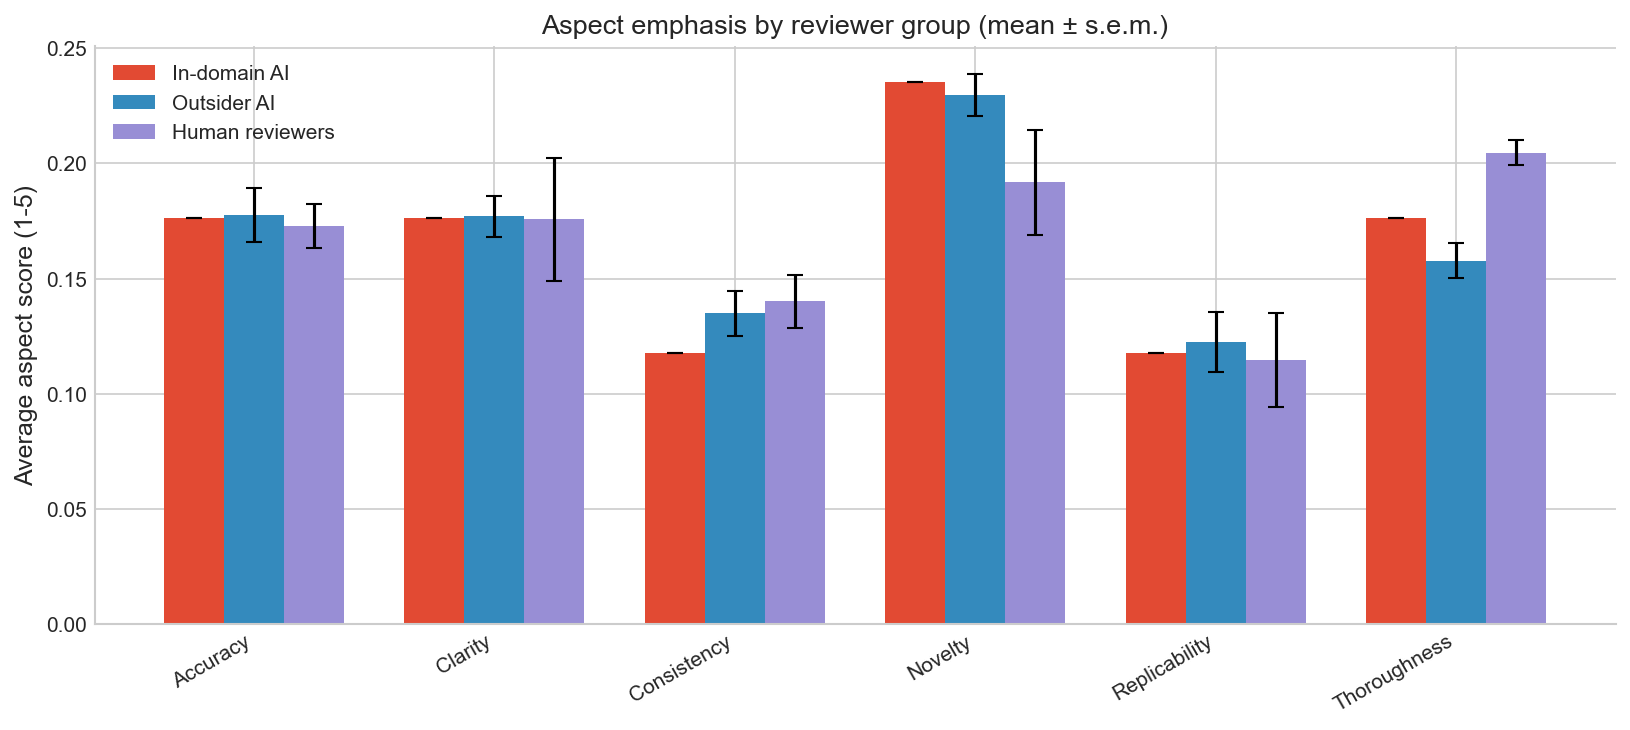

Sample of scored reviews with group labels:


,reviewer,domain_source,accuracy,clarity,consistency,novelty,replicability,thoroughness
0,AI Reviewer_1: Junior faculty in Causality,same,0.176471,0.176471,0.117647,0.235294,0.117647,0.176471
1,AI Reviewer_2: Junior faculty in Causality,same,0.176471,0.176471,0.117647,0.235294,0.117647,0.176471
2,AI Reviewer_3: Junior faculty in Causality,same,0.176471,0.176471,0.117647,0.235294,0.117647,0.176471
3,AI Reviewer_4: Junior faculty in Causality,same,0.176471,0.176471,0.117647,0.235294,0.117647,0.176471
4,AI Reviewer_5: Junior faculty in Causality,same,0.176471,0.176471,0.117647,0.235294,0.117647,0.176471


In [148]:
# Compare aspect focus for in-domain vs outsider AI reviews and humans
if not AI_REVIEWS:
    raise RuntimeError("Run the AI review generation cell before analyzing aspects.")
if "ASPECT_SCORES_DF" not in globals() or ASPECT_SCORES_DF.empty:
    raise RuntimeError("ASPECT_SCORES_DF is empty; run the earlier scoring cells first.")

persona_lookup = {persona.name: persona for persona in personas}
review_records_for_scoring: List[Dict[str, Any]] = []
domain_labels: Dict[str, str] = {}

for idx, review in enumerate(AI_REVIEWS, start=1):
    reviewer_name = review.get("reviewer", f"ai_reviewer_{idx}")
    persona_obj = persona_lookup.get(reviewer_name)
    if persona_obj is None:
        continue
    domain_source = "same" if persona_obj.expertise == PAPER_DOMAIN else "random_different"
    domain_labels[reviewer_name] = domain_source
    review_records_for_scoring.append(
        {
            "persona": {
                "name": reviewer_name,
                "expertise": persona_obj.expertise,
                "seniority": persona_obj.seniority,
            },
            "response": review.get("response", ""),
        }
    )

if not review_records_for_scoring:
    raise RuntimeError("No review records available for aspect analysis.")

scored_domain_records = score_ai_review_records(review_records_for_scoring, source_label="AI")
scored_domain_df = pd.DataFrame(scored_domain_records)
if scored_domain_df.empty:
    raise RuntimeError("Aspect scoring returned an empty result; rerun the reviews cell.")

scored_domain_df["domain_source"] = scored_domain_df["reviewer"].map(domain_labels).fillna("unknown")
scored_domain_df = scored_domain_df[scored_domain_df["domain_source"].isin(["same", "random_different"])]
if scored_domain_df.empty:
    raise RuntimeError("No reviews classified as same-domain or outsider; regenerate AI reviews.")

human_scores_df = ASPECT_SCORES_DF[ASPECT_SCORES_DF["source"].str.lower() == "human"].copy()
if human_scores_df.empty:
    raise RuntimeError("Human review aspect scores are missing; load and score human reviews first.")
if "reviewer" not in human_scores_df.columns:
    if "name" in human_scores_df.columns:
        human_scores_df["reviewer"] = human_scores_df["name"]
    else:
        human_scores_df["reviewer"] = [f"human_{i+1}" for i in range(len(human_scores_df))]
human_scores_df["domain_source"] = "human"

columns_needed = ["reviewer", "domain_source"] + ASPECT_COLUMNS
ai_subset = scored_domain_df[columns_needed].copy()
human_subset = human_scores_df.reindex(columns=columns_needed)
comparison_df = pd.concat([ai_subset, human_subset], ignore_index=True)

aspects_by_domain = comparison_df.groupby("domain_source")[ASPECT_COLUMNS].mean()
aspect_sem = comparison_df.groupby("domain_source")[ASPECT_COLUMNS].sem().fillna(0)
order = [label for label in ["same", "random_different", "human"] if label in aspects_by_domain.index]
aspects_by_domain = aspects_by_domain.reindex(order)
aspect_sem = aspect_sem.reindex(order).fillna(0)

label_map = {
    "same": "In-domain AI",
    "random_different": "Outsider AI",
    "human": "Human reviewers",
}

print("Average aspect scores by reviewer group:")
display(aspects_by_domain.rename(index=label_map))
print("Standard error of the mean per aspect:")
display(aspect_sem.rename(index=label_map))

x = np.arange(len(ASPECT_COLUMNS))
bar_width = 0.25
fig, ax = plt.subplots(figsize=(11, 5))

for idx, group_key in enumerate(order):
    offset = (idx - (len(order) - 1) / 2) * bar_width
    ax.bar(
        x + offset,
        aspects_by_domain.loc[group_key].values,
        bar_width,
        label=label_map[group_key],
        yerr=aspect_sem.loc[group_key].values,
        capsize=4,
    )

ax.set_xticks(x)
ax.set_xticklabels([col.title() for col in ASPECT_COLUMNS], rotation=30, ha="right")
ax.set_ylabel("Average aspect score (1-5)")
ax.set_title("Aspect emphasis by reviewer group (mean ± s.e.m.)")
# ax.set_ylim(0, 5)
ax.legend()
plt.tight_layout()
plt.show()

print("Sample of scored reviews with group labels:")
display(comparison_df[["reviewer", "domain_source"] + ASPECT_COLUMNS].head())

# How does the number of outsider reviews affect the editor's decision?

Outsider reviewer simulations: 100%|██████████| 18/18 [01:13<00:00,  4.08s/it]


{'panel_size': 5, 'runs_per_setting': 3, 'outsider_counts': [0, 1, 2, 3, 4, 5]}

,num_outsiders,num_same,run_idx,selected_reviewers,editor_response,parsed_decision,parsed_confidence
0,0,5,0,"[AI Reviewer_3: Junior faculty in Causality, A...","{\n ""decision"": ""Accept (Poster)"",\n ""confid...",Accept (Poster),0.85
1,0,5,1,"[AI Reviewer_4: Junior faculty in Causality, A...","{\n ""decision"": ""Accept (Poster)"",\n ""confid...",Accept (Poster),0.80
2,0,5,2,"[AI Reviewer_1: Junior faculty in Causality, A...","{\n ""decision"": ""Accept (Poster)"",\n ""confid...",Accept (Poster),0.85
3,1,4,0,"[AI Reviewer_2: Junior faculty in Causality, A...","{\n ""decision"": ""Accept (Poster)"",\n ""confid...",Accept (Poster),0.85
4,1,4,1,[AI Reviewer_7: Junior faculty in Recommender ...,"{\n ""decision"": ""Accept (Poster)"",\n ""confid...",Accept (Poster),0.80


Editor decision counts by number of outsider reviewers:


parsed_decision,Accept (Poster)
num_outsiders,
0,3
1,3
2,3
3,3
4,3
5,3


Editor confidence by number of outsider reviewers:


,mean,std,count,sem
num_outsiders,,,,
0,0.833333,0.028868,3,0.016667
1,0.833333,0.028868,3,0.016667
2,0.850000,0.000000,3,0.000000
3,0.833333,0.028868,3,0.016667
4,0.850000,0.000000,3,0.000000
5,0.833333,0.028868,3,0.016667


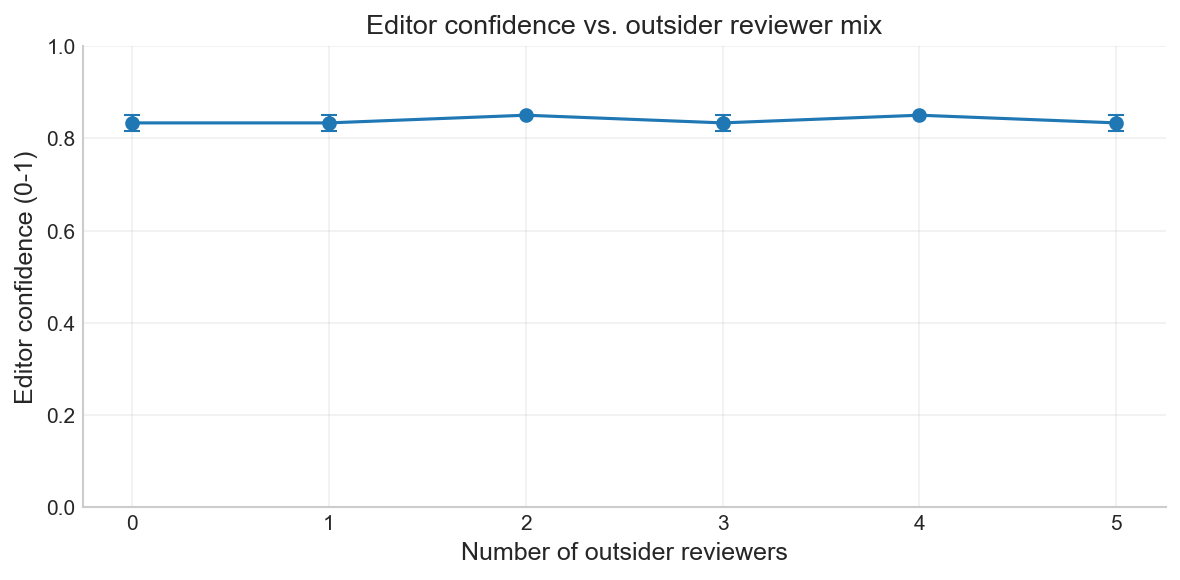

In [149]:

OUTSIDER_PANEL_SIZE = min(5, len(AI_REVIEWS))
OUTSIDER_RUNS_PER_SETTING = 3

if OUTSIDER_PANEL_SIZE == 0:
    raise RuntimeError("Generate AI reviews for the mixed-domain panel before running this cell.")

persona_lookup = {persona.name: persona for persona in personas}

def _infer_domain_source(persona_obj: Optional[ReviewerPersona]) -> str:
    if persona_obj is None:
        return "unknown"
    return "same" if persona_obj.expertise == PAPER_DOMAIN else "random_different"

review_records: List[Dict[str, Any]] = []
for idx, review in enumerate(AI_REVIEWS, start=1):
    reviewer_name = review.get("reviewer", f"ai_reviewer_{idx}")
    persona_obj = persona_lookup.get(reviewer_name)
    domain_source = _infer_domain_source(persona_obj)
    review_text = flatten_review_text_ai(review)
    if not review_text:
        continue
    review_records.append(
        {
            "reviewer": reviewer_name,
            "domain_source": domain_source,
            "text": review_text,
        }
    )

if not review_records:
    raise RuntimeError("AI_REVIEWS is empty after filtering; rerun generate_ai_reviews().")

same_domain_records = [r for r in review_records if r["domain_source"] == "same"]
outsider_records = [r for r in review_records if r["domain_source"] != "same"]

if not same_domain_records or not outsider_records:
    raise RuntimeError("Need both same-domain and outsider reviews to run this experiment.")

if len(same_domain_records) < OUTSIDER_PANEL_SIZE:
    raise RuntimeError(
        f"Not enough same-domain reviews ({len(same_domain_records)}) to fill a panel of {OUTSIDER_PANEL_SIZE} reviewers."
    )

max_outsiders_allowed = min(len(outsider_records), OUTSIDER_PANEL_SIZE)
outsider_counts = list(range(0, max_outsiders_allowed + 1))

OUTSIDER_EXPERIMENT_CONFIG = {
    "panel_size": OUTSIDER_PANEL_SIZE,
    "runs_per_setting": OUTSIDER_RUNS_PER_SETTING,
    "outsider_counts": outsider_counts,
}

OUTSIDER_EDITOR_EXPERIMENT_RESULTS: List[Dict[str, Any]] = []
total_runs = len(outsider_counts) * OUTSIDER_RUNS_PER_SETTING

with tqdm(total=total_runs, desc="Outsider reviewer simulations") as pbar:
    for num_outsiders in outsider_counts:
        num_same_needed = OUTSIDER_PANEL_SIZE - num_outsiders
        if num_same_needed > len(same_domain_records):
            continue
        for run_idx in range(OUTSIDER_RUNS_PER_SETTING):
            selected_same = random.sample(same_domain_records, num_same_needed) if num_same_needed else []
            selected_outsiders = random.sample(outsider_records, num_outsiders) if num_outsiders else []
            selected_records = selected_same + selected_outsiders
            random.shuffle(selected_records)

            reviews_text = "\n\n---\n\n".join(
                [
                    f"{rec['reviewer']} ({rec['domain_source']}):\n{rec['text']}"
                    for rec in selected_records
                ]
            )

            input_message = (
                f"Paper:\n{PAPER_TEXT}\n\n"
                f"Please make a decision for this paper based on the following reviews:\n\n{reviews_text}"
            )

            editor = make_editor_agent()
            response = editor.generate_reply(messages=[{"role": "user", "content": input_message}])

            OUTSIDER_EDITOR_EXPERIMENT_RESULTS.append(
                {
                    "num_outsiders": num_outsiders,
                    "num_same": num_same_needed,
                    "run_idx": run_idx,
                    "selected_reviewers": [rec["reviewer"] for rec in selected_records],
                    "editor_response": response,
                    "parsed_decision": parse_editor_decision(response),
                    "parsed_confidence": parse_editor_confidence(response),
                }
            )
            pbar.update(1)

outsider_results_df = pd.DataFrame(OUTSIDER_EDITOR_EXPERIMENT_RESULTS)
display(OUTSIDER_EXPERIMENT_CONFIG)
display(outsider_results_df.head())

if not outsider_results_df.empty:
    decision_summary = (
        outsider_results_df.groupby(["num_outsiders", "parsed_decision"])
        .size()
        .unstack(fill_value=0)
        .reindex(index=outsider_counts, fill_value=0)
    )
    print("Editor decision counts by number of outsider reviewers:")
    display(decision_summary)

    if outsider_results_df["parsed_confidence"].notna().any():
        confidence_summary = (
            outsider_results_df.groupby("num_outsiders")["parsed_confidence"]
            .agg(["mean", "std", "count"])
            .reindex(index=outsider_counts)
        )
        confidence_summary = confidence_summary.fillna({"count": 0})
        sem = confidence_summary["std"] / np.sqrt(confidence_summary["count"].replace(0, np.nan))
        confidence_summary["sem"] = sem.fillna(0)
        print("Editor confidence by number of outsider reviewers:")
        display(confidence_summary)

        fig, ax = plt.subplots(figsize=(8, 4))
        ax.errorbar(
            confidence_summary.index,
            confidence_summary["mean"],
            yerr=confidence_summary["sem"],
            fmt="-o",
            capsize=4,
            color="#1f77b4",
        )
        ax.set_xlabel("Number of outsider reviewers")
        ax.set_ylabel("Editor confidence (0-1)")
        ax.set_title("Editor confidence vs. outsider reviewer mix")
        ax.set_ylim(0, 1)
        ax.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("Editor confidences could not be parsed for these simulations.")
else:
    print("No simulations were recorded; verify AI reviews exist and rerun this cell.")

In [150]:
outsider_results_df

,num_outsiders,num_same,run_idx,selected_reviewers,editor_response,parsed_decision,parsed_confidence
0,0,5,0,"[AI Reviewer_3: Junior faculty in Causality, A...","{\n ""decision"": ""Accept (Poster)"",\n ""confid...",Accept (Poster),0.85
1,0,5,1,"[AI Reviewer_4: Junior faculty in Causality, A...","{\n ""decision"": ""Accept (Poster)"",\n ""confid...",Accept (Poster),0.80
2,0,5,2,"[AI Reviewer_1: Junior faculty in Causality, A...","{\n ""decision"": ""Accept (Poster)"",\n ""confid...",Accept (Poster),0.85
3,1,4,0,"[AI Reviewer_2: Junior faculty in Causality, A...","{\n ""decision"": ""Accept (Poster)"",\n ""confid...",Accept (Poster),0.85
4,1,4,1,[AI Reviewer_7: Junior faculty in Recommender ...,"{\n ""decision"": ""Accept (Poster)"",\n ""confid...",Accept (Poster),0.80
5,1,4,2,"[AI Reviewer_5: Junior faculty in Causality, A...","{\n ""decision"": ""Accept (Poster)"",\n ""confid...",Accept (Poster),0.85
6,2,3,0,"[AI Reviewer_2: Junior faculty in Causality, A...","{\n ""decision"": ""Accept (Poster)"",\n ""confid...",Accept (Poster),0.85
7,2,3,1,"[AI Reviewer_5: Junior faculty in Causality, A...","{\n ""decision"": ""Accept (Poster)"",\n ""confid...",Accept (Poster),0.85
8,2,3,2,[AI Reviewer_9: Junior faculty in Autonomous S...,"{\n ""decision"": ""Accept (Poster)"",\n ""confid...",Accept (Poster),0.85
9,3,2,0,"[AI Reviewer_3: Junior faculty in Causality, A...","{\n ""decision"": ""Accept (Poster)"",\n ""confid...",Accept (Poster),0.80


# Summarization Data Pack
Use the next cell to print a compact JSON summary of your run. After it finishes:

1. Right-click the cell output and choose **Copy Cell Output**.
2. Paste the JSON into the shared Google Sheet so we can combine everyone’s results.

Make sure you’ve generated AI reviews and run the simulation cells before executing the exporter.

In [152]:
# Export a JSON-friendly summary for classroom aggregation
from datetime import datetime

def _to_serializable(value):
    """Best-effort conversion of numpy/pandas types into JSON-safe values."""
    if isinstance(value, (np.integer, np.int64, np.int32)):
        return int(value)
    if isinstance(value, (np.floating, np.float64, np.float32)):
        return float(value)
    if isinstance(value, np.bool_):
        return bool(value)
    if isinstance(value, (list, tuple, set)):
        return [_to_serializable(v) for v in value]
    if isinstance(value, dict):
        return {k: _to_serializable(v) for k, v in value.items()}
    if isinstance(value, pd.DataFrame):
        return [_to_serializable(row) for row in value.to_dict(orient="records")]
    if isinstance(value, pd.Series):
        return _to_serializable(value.to_dict())
    return value

def _safe_df_records(df: Optional[pd.DataFrame]) -> List[Dict[str, Any]]:
    if df is None or df.empty:
        return []
    return [
        {k: _to_serializable(v) for k, v in row.items()}
        for row in df.to_dict(orient="records")
    ]

def build_classroom_datapack(indent: int = 2) -> Dict[str, Any]:
    """Collect review aspects + editor outcomes into a sharable JSON blob."""
    pack: Dict[str, Any] = {
        "generated_at": datetime.utcnow().isoformat() + "Z",
        "paper": {
            "paper_id": locals().get("PAPER_ID", "unknown"),
            "paper_domain": locals().get("PAPER_DOMAIN", "unknown"),
        },
        "ai_panel_state": AI_PANEL_STATE,
    }

    if 'ASPECT_SCORES_DF' in globals() and not ASPECT_SCORES_DF.empty:
        aspect_df = ASPECT_SCORES_DF.copy()
        pack["aspect_scores"] = {
            "mean_by_source": _to_serializable(
                aspect_df.groupby("source")[ASPECT_COLUMNS].mean().round(4).to_dict(orient="index")
            ),
            "std_by_source": _to_serializable(
                aspect_df.groupby("source")[ASPECT_COLUMNS].std(ddof=0).round(4).to_dict(orient="index")
            ),
            "mean_by_domain": _to_serializable(
                aspect_df.groupby("domain")[ASPECT_COLUMNS].mean().round(4).to_dict(orient="index")
            ),
            "std_by_domain": _to_serializable(
                aspect_df.groupby("domain")[ASPECT_COLUMNS].std(ddof=0).round(4).to_dict(orient="index")
            ),
            "counts_by_source": _to_serializable(
                aspect_df.groupby("source").size().to_dict()
            ),
            "counts_by_domain": _to_serializable(
                aspect_df.groupby("domain").size().to_dict()
            ),
        }

    if 'AI_REVIEWS' in globals() and AI_REVIEWS:
        pack["ai_review_personas"] = [review.get("reviewer") for review in AI_REVIEWS]

    if 'AI_EDITOR_AI_REVIEWERS_SIMULATION_RESULTS' in globals() and AI_EDITOR_AI_REVIEWERS_SIMULATION_RESULTS:
        mixture_df = pd.DataFrame(AI_EDITOR_AI_REVIEWERS_SIMULATION_RESULTS)
        if "parsed_confidence" not in mixture_df.columns:
            mixture_df["parsed_confidence"] = mixture_df["editor_response"].map(parse_editor_confidence)
        pack["human_ai_mixture"] = {
            "config": {
                "num_ai_reviews_tested": NUM_AI_REVIEWS_TO_TEST,
                "num_shuffle_runs": NUM_SHUFFLE_RUNS,
            },
            "runs": _safe_df_records(
                mixture_df[
                    [
                        "num_ai_reviews",
                        "run_idx",
                        "replacement_indices",
                        "review_sources",
                        "parsed_decision",
                        "parsed_confidence",
                    ]
                ]
            ),
            "decision_counts": _to_serializable(
                mixture_df.groupby(["num_ai_reviews", "parsed_decision"])
                .size()
                .unstack(fill_value=0)
                .to_dict(orient="index")
            ),
        }

    if 'OUTSIDER_EDITOR_EXPERIMENT_RESULTS' in globals() and OUTSIDER_EDITOR_EXPERIMENT_RESULTS:
        outsider_df = pd.DataFrame(OUTSIDER_EDITOR_EXPERIMENT_RESULTS)
        pack["outsider_mixture"] = {
            "config": OUTSIDER_EXPERIMENT_CONFIG,
            "runs": _safe_df_records(
                outsider_df[
                    [
                        "num_outsiders",
                        "num_same",
                        "run_idx",
                        "parsed_decision",
                        "parsed_confidence",
                    ]
                ]
            ),
            "decision_counts": _to_serializable(
                outsider_df.groupby(["num_outsiders", "parsed_decision"])
                .size()
                .unstack(fill_value=0)
                .to_dict(orient="index")
            ),
            "confidence_summary": _safe_df_records(
                outsider_df.groupby("num_outsiders")["parsed_confidence"]
                .agg(["mean", "std", "count"])
                .reset_index()
            ),
        }

    json_payload = json.dumps(_to_serializable(pack), indent=indent, ensure_ascii=False)
    print(json_payload)
    return pack

classroom_pack = build_classroom_datapack()

{
  "generated_at": "2025-12-01T05:23:37.447648Z",
  "paper": {
    "paper_id": "unknown",
    "paper_domain": "unknown"
  },
  "ai_panel_state": [
    {
      "domain": "same",
      "seniority": "Junior faculty"
    },
    {
      "domain": "same",
      "seniority": "Junior faculty"
    },
    {
      "domain": "same",
      "seniority": "Junior faculty"
    },
    {
      "domain": "same",
      "seniority": "Junior faculty"
    },
    {
      "domain": "same",
      "seniority": "Junior faculty"
    },
    {
      "domain": "random_different",
      "seniority": "Junior faculty"
    },
    {
      "domain": "random_different",
      "seniority": "Junior faculty"
    },
    {
      "domain": "random_different",
      "seniority": "Junior faculty"
    },
    {
      "domain": "random_different",
      "seniority": "Junior faculty"
    },
    {
      "domain": "random_different",
      "seniority": "Junior faculty"
    }
  ],
  "aspect_scores": {
    "mean_by_source": {
      "AI": {